# Model Development

This notebook contains the work done to create and fit a NN for nfl game spread prediction. The model takes in the difference in average values looking back 14 games between two teams for elo, points, yards, turnovers, and the Elo Model predicted spread for that game. Essentially, the model is correcting the Elo prediction based on past elo, points, yards, and turnovers. 

In [ ]:
import os
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
conn = sqlite3.connect('../db.sqlite')
cur = conn.cursor()

# get data by joining game and mldata tables
games = cur.execute("""
                    SELECT Games.home_points, Games.away_points,
                    Games.home_pregame_elo, Games.away_pregame_elo, MLData.*
                    FROM Games JOIN MLData on Games.id = MLData.game_id""").fetchall()
conn.close()

In [4]:
# only the most previous 6 games in the average
games_df = pd.DataFrame(games)
games_df["error"] = games_df.iloc[:,1] - games_df.iloc[:,0] - round((games_df.iloc[:,3] - games_df.iloc[:,2])/25)
games_df["home_point_diff"] = games_df.iloc[:,42:49].mean(axis=1) - games_df.iloc[:,56:63].mean(axis=1)
games_df["away_point_diff"] = games_df.iloc[:,155:162].mean(axis=1) - games_df.iloc[:,169:176].mean(axis=1)
games_df["point_diff_diff"] = games_df["home_point_diff"] - games_df["away_point_diff"]
games_df["home_turnover_diff"] = games_df.iloc[:,98:105].mean(axis=1) - games_df.iloc[:,112:119].mean(axis=1)
games_df["away_turnover_diff"] = games_df.iloc[:,211:218].mean(axis=1) - games_df.iloc[:,225:232].mean(axis=1)
games_df["turnover_diff_diff"] = games_df["home_turnover_diff"] - games_df["away_turnover_diff"]
games_df["home_yard_diff"] = games_df.iloc[:,70:77].mean(axis=1) - games_df.iloc[:,84:91].mean(axis=1)
games_df["away_yard_diff"] = games_df.iloc[:,183:190].mean(axis=1) - games_df.iloc[:,197:204].mean(axis=1)
games_df["yard_diff_diff"] = games_df["home_yard_diff"] - games_df["away_yard_diff"]
games_df["home_elo_diff"] = games_df.iloc[:,14:21].mean(axis=1) - games_df.iloc[:,28:35].mean(axis=1)
games_df["away_elo_diff"] = games_df.iloc[:,127:134].mean(axis=1) - games_df.iloc[:,141:148].mean(axis=1)
games_df["elo_diff_diff"] = games_df["home_elo_diff"] - games_df["away_elo_diff"]
games_df["pred_spread"] = (games_df.iloc[:, 3] - games_df.iloc[:, 2])/25
games_final = games_df

In [25]:
# all 14 previous games
games_df = pd.DataFrame(games)
games_df["error"] = games_df.iloc[:,1] - games_df.iloc[:,0] - round((games_df.iloc[:,3] - games_df.iloc[:,2])/25)
games_df["home_point_diff"] = games_df.iloc[:,35:49].mean(axis=1) - games_df.iloc[:,49:63].mean(axis=1)
games_df["away_point_diff"] = games_df.iloc[:,148:162].mean(axis=1) - games_df.iloc[:,162:176].mean(axis=1)
games_df["point_diff_diff"] = games_df["home_point_diff"] - games_df["away_point_diff"]
games_df["home_turnover_diff"] = games_df.iloc[:,91:105].mean(axis=1) - games_df.iloc[:,105:119].mean(axis=1)
games_df["away_turnover_diff"] = games_df.iloc[:,204:218].mean(axis=1) - games_df.iloc[:,218:232].mean(axis=1)
games_df["turnover_diff_diff"] = games_df["home_turnover_diff"] - games_df["away_turnover_diff"]
games_df["home_yard_diff"] = games_df.iloc[:,63:77].mean(axis=1) - games_df.iloc[:,77:91].mean(axis=1)
games_df["away_yard_diff"] = games_df.iloc[:,176:190].mean(axis=1) - games_df.iloc[:,190:204].mean(axis=1)
games_df["yard_diff_diff"] = games_df["home_yard_diff"] - games_df["away_yard_diff"]
games_df["home_elo_diff"] = games_df.iloc[:,7:21].mean(axis=1) - games_df.iloc[:,21:35].mean(axis=1)
games_df["away_elo_diff"] = games_df.iloc[:,120:134].mean(axis=1) - games_df.iloc[:,134:148].mean(axis=1)
games_df["elo_diff_diff"] = games_df["home_elo_diff"] - games_df["away_elo_diff"]
games_df["pred_spread"] = (games_df.iloc[:, 3] - games_df.iloc[:, 2])/25
games_final = games_df

In [26]:
games_final

,0,1,2,3,4,5,6,7,8,9,...,home_turnover_diff,away_turnover_diff,turnover_diff_diff,home_yard_diff,away_yard_diff,yard_diff_diff,home_elo_diff,away_elo_diff,elo_diff_diff,pred_spread
0,42,34,1531,1479,1,268,1531,1480,1529,1561,...,0.500000,-0.500000,1.000000,-3.500000,2.785714,-6.285714,43.357143,16.142857,27.214286,-2.08
1,13,31,1534,1476,2,269,1534,1530,1475,1505,...,0.285714,0.000000,0.285714,9.357143,-2.785714,12.142857,2.857143,22.500000,-19.642857,-2.32
2,34,7,1531,1479,3,270,1531,1531,1573,1565,...,0.000000,0.428571,-0.428571,10.285714,17.857143,-7.571429,38.785714,15.642857,23.142857,-2.08
3,16,14,1530,1480,4,271,1530,1532,1489,1511,...,0.285714,-1.142857,1.428571,-13.928571,44.000000,-57.928571,17.857143,11.714286,6.142857,-2.00
4,35,7,1529,1481,5,272,1529,1481,1464,1472,...,-0.071429,0.000000,-0.071429,31.142857,25.714286,5.428571,24.285714,38.785714,-14.500000,-1.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,23,34,1523,1585,2684,3444,1523,1612,1479,1487,...,-0.285714,0.214286,-0.500000,23.071429,34.642857,-11.571429,27.214286,-1.571429,28.785714,2.48
2684,17,14,1492,1455,2685,3445,1492,1605,1529,1517,...,0.285714,-0.428571,0.714286,-7.214286,-52.500000,45.285714,-23.714286,16.428571,-40.142857,-1.48
2685,12,20,1544,1511,2686,3446,1544,1458,1530,1521,...,0.142857,-0.071429,0.214286,-0.571429,-36.857143,36.285714,-27.357143,20.285714,-47.642857,-1.32
2686,30,24,1455,1504,2687,3447,1455,1438,1481,1490,...,-0.357143,0.142857,-0.500000,3.714286,12.928571,-9.214286,-39.714286,-27.000000,-12.714286,1.96


# Format Data into PyTorch Data Objects

In [27]:
class GameDataset(Dataset):
    def __init__(self, games, transform=None, target_transform=None):
        self.labels = (games.iloc[:, 1] - games.iloc[:, 0]).to_numpy()
        self.input = games[["elo_diff_diff","point_diff_diff","yard_diff_diff","turnover_diff_diff","pred_spread"]].to_numpy()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        label = self.labels[index:index+1]
        model_input = self.input[index]
        if self.transform:
            model_input = self.transform(model_input, dtype=torch.float32)
        if self.target_transform:
            label = self.target_transform(label, dtype=torch.float32)
        return model_input, label
    
dataset = GameDataset(games_final, torch.tensor, torch.tensor)
gen1 = torch.Generator().manual_seed(42)
train, test = random_split(dataset, [0.7, 0.3], generator=gen1)

train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test, batch_size=64, shuffle=True)

In [28]:
test_input = torch.tensor(games_final[["elo_diff_diff","point_diff_diff","yard_diff_diff","turnover_diff_diff","pred_spread"]].to_numpy()[0],
                          dtype=torch.float32)

In [29]:
test_input

tensor([27.2143,  6.3571, -6.2857,  1.0000, -2.0800])

# Build and Train the Network

The NN built is a simple single hidden layer model with 5 inputs, 5 hidden neurons, and a ReLu activation function. Larger Models were tested, along with normalization and no normalization, and different activation functions, learning rates, and loss functions. However, all other models tended to either overfit or underperform. This is likely due to the input data not providing a lot of additional information to the model. It is believed that adding quaterback and key player statistics to the input will improve the model.

In [30]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# build the network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
        )

    def forward(self, x):
        output = self.linear_relu_stack(x)
        return output

Using cpu device


In [31]:
def train_loop(dataloader, model, loss_fn, optimizer):
    loss_arr = []
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # backpropogate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_arr.append(loss.item())

    return np.mean(loss_arr)

def test_loop(dataloader, model, loss_fn):

    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    loss = []
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss = loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            loss.append(test_loss)

    return np.mean(loss)

In [32]:
model = NeuralNetwork()
learning_rate = 1e-3
batch_size = 64
epochs = 60
loss_fn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
loss = []
val_loss = []
for t in range(epochs):
    loss.append(train_loop(train_dataloader, model, loss_fn, optimizer))
    val_loss.append(test_loop(test_dataloader, model, loss_fn))

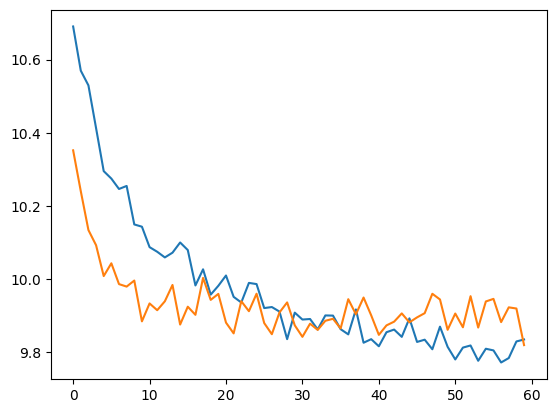

In [34]:
%matplotlib inline
plt.clf()
plt.plot(loss)
plt.plot(val_loss);
plt.show()

In [38]:
games_df["error"].mean()

-0.6443452380952381

In [35]:
actual = np.array([])
predicted = np.array([])
elo_pred = np.array([])
model.eval()
for feature, label in test_dataloader:
    # predicted = np.concatenate((predicted, model(feature).detach().numpy().ravel()))
    predicted = np.concatenate((predicted, 
                                model(feature).detach().numpy().ravel()))
    actual = np.concatenate((actual, label.detach().numpy().ravel()))
    elo_pred = np.concatenate((elo_pred, feature[:,-1].detach().numpy().ravel()))

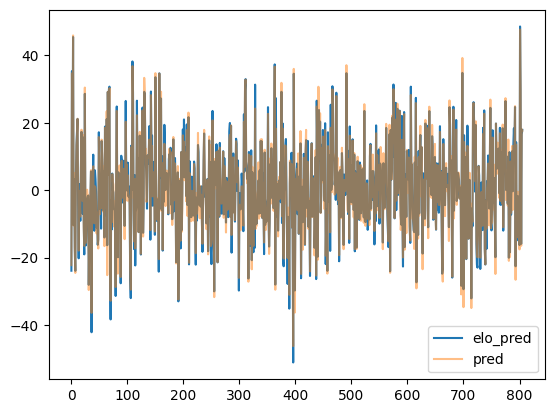

In [36]:
%matplotlib inline
plt.clf()
# plt.plot(actual, label='actual')
plt.plot(elo_pred - actual, label='elo_pred')
plt.plot(predicted - actual, label='pred', alpha=0.5)
plt.legend()
plt.show()

In [37]:
print(np.mean(np.abs(elo_pred - actual)))
print(np.mean(np.abs(predicted - actual)))

10.573598013492878
10.381246410846414


Here we see that the model only improves the Elo model by about a quarter of a point. This suggests that including it in the website is nonsensical, however, doing so provides the opportunity to improve the model without making too many changes to the website architecture.

In [38]:
torch.save(model.state_dict(), '../models/v1.pth')

# Misc

In [63]:
train_features, train_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
input_data = train_features[0:1]
label = train_labels[0]
print(f"input_data: {input_data}")
print(f"Label: {label}")
pred = model(input_data)
print(f"pred: {pred}")

Feature batch shape: torch.Size([64, 5])
Labels batch shape: torch.Size([64, 1])
input_data: tensor([[-51.4286, -10.3571,  22.6429,  -1.2143,   1.5600]])
Label: tensor([7.])
pred: tensor([[3.6056]], grad_fn=<AddmmBackward0>)


In [11]:
model = NeuralNetwork()
model.load_state_dict(torch.load('../models/v1.pth'))
model.eval()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=5, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [12]:
model(test_input)

tensor([-4.2387], grad_fn=<AddBackward0>)